In [1]:
import dicom # The only library for reading dicom files
import os # for doing directory operations 
import pandas as pd # To load data in the labels data and quickly reference it
import pprint
import math
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


/home/sdash/.local/lib/python2.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
# Change this to wherever you are storing your data:
# IF YOU ARE FOLLOWING O
#N KAGGLE, YOU CAN ONLY PLAY WITH THE SAMPLE DATA, WHICH IS MUCH SMALLER

data_dir = '/scratch2/sdash/data/stage1'
patients = os.listdir(data_dir)
patients.sort()
#print(patients[0])
labels_df = pd.read_csv('/scratch2/sdash/data/stage1_labels.csv', index_col=0)

labels_df.head()

3.2.0


,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


2


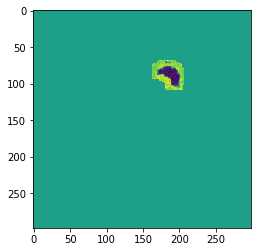

In [10]:
#using our saved numpy array to load the data
much_data = np.load('TensorflowData.npy')
print(len(much_data))
#print(much_data)
plt.imshow(much_data[1][0][1])

In [2]:
#Largely inspired from MNIST Deep Tutorial in the website https://www.tensorflow.org

import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np

#tf.device('/gpu:0')  #was trying to 
IMG_SIZE_PX = 64
SLICE_COUNT = 32

n_classes = 2
batch_size = 100

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

In [3]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')


In [4]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([5,5,5,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([5,5,5,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([131072,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 131072])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output


In [5]:
#Loading of our data which were kept as different batch of data.

load_data = np.load('TensorflowData.npy')
load_data1 = np.load('TensorflowData1.npy')
load_data2 = np.load('TensorflowData2.npy')
load_data3 = np.load('TensorflowData3.npy')

print(load_data.shape)
print(load_data1.shape)
final_data = np.append(load_data,load_data1,0)
print(final_data.shape)
print(load_data2.shape)
final_data = np.append(final_data,load_data2,0)
print(final_data.shape)
print(load_data3.shape)
final_data = np.append(final_data,load_data3,0)
print(final_data.shape)


(200, 3)
(299, 3)
(499, 3)
(249, 3)
(748, 3)
(646, 3)
(1394, 3)


In [ ]:
#much_data = np.load('muchdata-50-50-20.npy')
much_data = final_data

# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-200]
validation_data = much_data[-200:]


def train_neural_network(x):
    
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    #saver = tf.train.Saver()
    hm_epochs = 6
    with tf.Session() as sess:
        print ("Session Started")
        #sess.run(tf.initialize_all_variables())
        sess.run(tf.global_variables_initializer())
        successful_runs = 0
        total_runs = 0
        
        #saver.restore(sess, "model.ckpt")

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                if(total_runs%100 == 0):
                    print(successful_runs) #for test
                total_runs += 1
                
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    print(str(e))
                    pass
                    
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            saver = tf.train.Saver()
            save_path = saver.save(sess, "MyModel.ckpt")
            print("Model saved in file: %s" % save_path)
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)

# Run this locally:
train_neural_network(x)

Session Started
0
100
200
300
400
500
600
700
800
900
1000


In [9]:
# we tried to save the moodel and restore it to submit it as a direct use but it did not work
saver = tf.train.Saver()
#save_path = saver.save(sess, "model.ckpt")
with tf.Session() as sess:
    saver.restore(sess, "model.ckpt")
    #print("Model saved in file: %s" % save_path)
    print("Model Restored")



NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for model.ckpt
	 [[Node: save_7/RestoreV2_2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_7/Const_0, save_7/RestoreV2_2/tensor_names, save_7/RestoreV2_2/shape_and_slices)]]

Caused by op u'save_7/RestoreV2_2', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-2b858264e619>", line 1, in <module>
    saver = tf.train.Saver()
  File "/home/sdash/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1040, in __init__
    self.build()
  File "/home/sdash/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1070, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/sdash/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/home/sdash/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/sdash/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/sdash/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/sdash/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/sdash/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/sdash/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for model.ckpt
	 [[Node: save_7/RestoreV2_2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_7/Const_0, save_7/RestoreV2_2/tensor_names, save_7/RestoreV2_2/shape_and_slices)]]


In [ ]:
import csv
    with open("stage1_label.csv", "r") as f1, \
     open("Stage2.csv", "w", newline='') as resultFile:
    wr = csv.writer(resultFile, dialect='excel')
    for var in f1:
        wr.writerow([var.rstrip('\n')])